In [25]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/large_student_dropout_dataset.csv")
print(df.shape)
df.head()


(5000, 8)


,attendance,cgpa,arrear_count,fees_paid,disciplinary_issues,year,semester,dropout
0,78,5.16,4,0,0,3,3,1
1,91,7.71,6,1,0,1,1,1
2,68,3.59,5,0,0,1,6,1
3,54,9.12,7,0,1,3,7,1
4,82,4.30,2,0,0,2,6,1


In [26]:
# Add 10% noise to dropout labels (simulate real-world uncertainty)
np.random.seed(42)
noise_mask = np.random.rand(len(df)) < 0.1
df.loc[noise_mask, "dropout"] = 1 - df.loc[noise_mask, "dropout"]

df["dropout"].value_counts()


,count
dropout,
1,4001
0,999


In [27]:
df["low_attendance"] = (df["attendance"] < 60).astype(int)
df["low_cgpa"] = (df["cgpa"] < 5).astype(int)
df["high_arrears"] = (df["arrear_count"] > 3).astype(int)
df["financial_risk"] = (df["fees_paid"] == 0).astype(int)
df["behavior_risk"] = df["disciplinary_issues"]


In [28]:
X = df.drop("dropout", axis=1)
y = df["dropout"]


In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("After SMOTE:", np.bincount(y_res))


After SMOTE: [4001 4001]


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [32]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=1,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
from sklearn.metrics import accuracy_score

y_pred = xgb.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))


Model Accuracy: 0.8881948782011243


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.85      0.88       785
           1       0.87      0.92      0.89       816

    accuracy                           0.89      1601
   macro avg       0.89      0.89      0.89      1601
weighted avg       0.89      0.89      0.89      1601



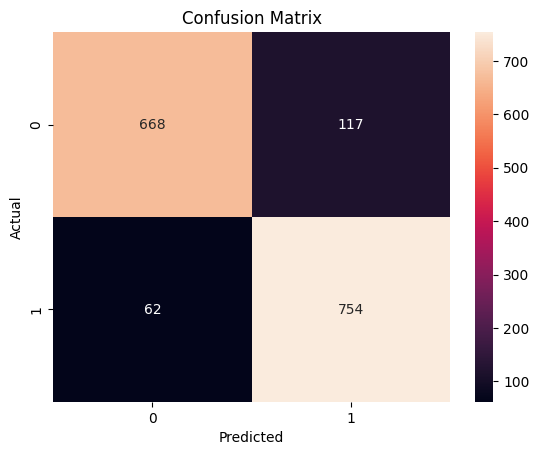

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


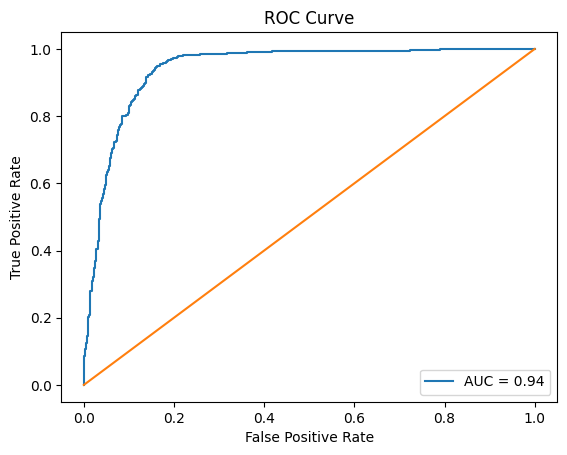

In [36]:
from sklearn.metrics import roc_curve, auc

y_prob = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = %0.2f" % roc_auc)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


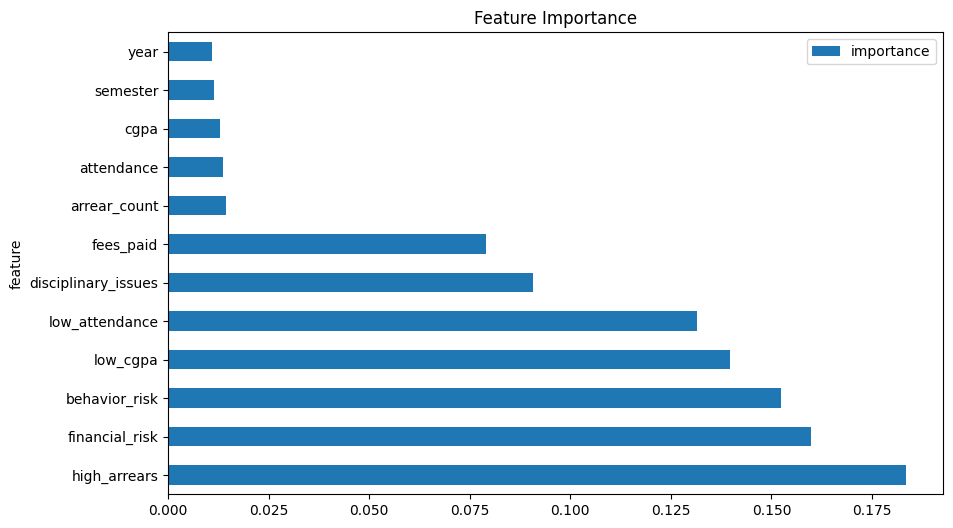

In [37]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.plot(kind="barh", x="feature", y="importance", figsize=(10,6))
plt.title("Feature Importance")
plt.show()


In [38]:
import joblib

joblib.dump(xgb, "model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


In [39]:
loaded_model = joblib.load("model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

y_pred_loaded = loaded_model.predict(X_test)
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded))


Loaded Model Accuracy: 0.8881948782011243


In [40]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    "n_estimators": [500, 800, 1000],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "subsample": [0.8, 0.9, 1],
    "colsample_bytree": [0.8, 0.9, 1]
}

xgb = XGBClassifier(eval_metric="logloss", random_state=42)

grid = GridSearchCV(
    xgb, param_grid, cv=3, scoring="accuracy", verbose=2, n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 800, 'subsample': 0.8}
Best Accuracy: 0.8754875154022573


In [41]:
best_xgb = grid.best_estimator_
best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)
from sklearn.metrics import accuracy_score
print("Tuned Accuracy:", accuracy_score(y_test, y_pred))


Tuned Accuracy: 0.8906933166770769


In [42]:
import joblib

joblib.dump(best_xgb, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Final industry model saved!")


Final industry model saved!


In [43]:
print(grid.best_params_)


{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 800, 'subsample': 0.8}


In [44]:
from xgboost import XGBClassifier
import joblib

# Retrain final model
final_model = XGBClassifier(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

final_model.fit(X_train, y_train)

# Verify Accuracy
from sklearn.metrics import accuracy_score
y_pred = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred))

# Save model & scaler for deployment
joblib.dump(final_model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Final model.pkl and scaler.pkl saved!")


Final Model Accuracy: 0.8906933166770769
Final model.pkl and scaler.pkl saved!
